## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [4]:
#compute gini 
def gini(sequence):
    c1, c2 = 0, 0
    for i in sequence:
        if i == 1:
            c1 += 1
        else :
            c2 += 1
    
    return 1 - pow((c1/len(sequence)), 2) - pow((c2/len(sequence)), 2)


import math
import numpy as np
#compute entropy
def entropy(sequence):
    c1, c2 = 0, 0
    for i in sequence:
        if i == 1:
            c1 += 1
        else :
            c2 += 1
    
    entro = - (((c1/len(sequence)) * math.log2(c1/len(sequence))) + ((c2/len(sequence)) * math.log2(c2/len(sequence))))
    return entro

In [5]:
# 1 = class 1,
# 2 = class 2
import pandas as pd
import numpy as np
import math
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
from collections import Counter
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [6]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [7]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006402


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [6]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
print(train_df.shape)
print(val_df.shape)


train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

x_train = train_df.drop(labels=["price_range"], axis="columns")
feature_names = x_train.columns.values
x_train = x_train.values
y_train = train_df['price_range'].values

x_test = val_df.drop(labels=["price_range"], axis="columns")
x_test = x_test.values
y_test = val_df['price_range'].values

train_df.head()

(1200, 21)
(300, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [8]:
#calculate the class in the leaf
def class_counts(y_train) :
    cl = 0
    c1, c2 = 0, 0
    for i in y_train:
        if i == 1:
            c1 += 1
        else :
            c2 += 1
    if c1 == len(y_train) or c2 == len(y_train) :
        return 3
    if c1 >= c2 : 
        cl = 1
    else : 
        cl = 0

    return cl

class Node:

    def __init__(self):
        self.col = None
        self.question = None
        self.cl = None
        self.depth = 0
        self.true_branch = None
        self.false_branch = None
        self.leaf = False

class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.max_depth = max_depth
        self.criterion = criterion
        self.x_data = None
        self.y_data = None
        self.tree = None
        self.features = []
        self.sample_weight = 1
        self.ada = False    
        self.max_features = 1
        self.boostrap = False

    #compute best decision for RandomForest
    def find_low_error(self, lists, x_data, y_data) :
        best_gain = None  
        best_question = None
        bestCol = None
        #iterate through features
        for col in lists: 
            val = []
            for i in x_data : 
                val.append(i[col])
            #iterate through every val in features
            for i in val : 
                
                true_col, false_col = [], []
                true_branch, false_branch = [], []
                true_w, false_w = [], []
                question = i
                if self.ada == True :
                    true_branch = y_data[val >= question]
                    true_col = [ index for index, i in enumerate(y_data[val >= question])]
                    true_w = [self.sample_weight[index] for index, i in enumerate(y_data[val >= question])]

                    false_branch = y_data[val < question]
                    false_col = [ index for index, i in enumerate(y_data[val < question])]
                    false_w = [self.sample_weight[index] for index, i in enumerate(y_data[val < question])]
                else :
                    true_branch = y_data[val >= question]
                    false_branch = y_data[val < question]

                if len(true_branch) == 0 or len(false_branch) == 0:
                    continue
                
                #use gini
                if self.criterion == 'gini' : 
                    if self.ada == False :
                        gain = ((len(true_branch)/len(y_data)) * gini(true_branch) + (len(false_branch)/len(y_data)) *gini(false_branch))
                    else :
                        gain = ((len(true_branch)/len(y_data)) * gini(true_branch) + (len(false_branch)/len(y_data)) *gini(false_branch))
                #use entropy
                elif self.criterion == 'entropy' :
                    
                    gain = ((len(true_branch)/len(y_data)) * entropy(true_branch) + (len(false_branch)/len(y_data)) * entropy(false_branch))
            
                if best_gain == None or gain <= best_gain:
                    bestCol = col
                    best_gain, best_question = gain, question
        
        return bestCol, best_gain, best_question
    #compute best decision
    def find_best_decision(self, x_data, y_data):
        best_gain = None  
        best_question = None
        bestCol = None  
        current_gini = gini(y_data)
        current_entropy = entropy(y_data)
        # print(self.criterion)
        if self.boostrap == True :
            #randomly selecr features
            lists =  np.random.choice(x_data.shape[1], self.max_features, replace = True)
            bestCol, best_gain, best_question = self.find_low_error(lists, x_data, y_data)
        else :
            #iterate through features
            for col in range(len(x_data[0])):
                val = []
                for i in x_data : 
                    val.append(i[col])
                
                #iterate through every val in features
                for i in val : 
                    
                    true_col, false_col = [], []
                    true_branch, false_branch = [], []
                    true_w, false_w = [], []
                    question = i
                    if self.ada == True :
                        true_branch = y_data[val >= question]
                        true_col = [ index for index, i in enumerate(y_data[val >= question])]
                        true_w = [self.sample_weight[index] for index, i in enumerate(y_data[val >= question])]

                        false_branch = y_data[val < question]
                        false_col = [ index for index, i in enumerate(y_data[val < question])]
                        false_w = [self.sample_weight[index] for index, i in enumerate(y_data[val < question])]
                    else :
                        true_branch = y_data[val >= question]
                        false_branch = y_data[val < question]

                    if len(true_branch) == 0 or len(false_branch) == 0:
                        continue
                    #use gini
                    if self.criterion == 'gini' : 
                        if self.ada == False :
                            gain = ((len(true_branch)/len(y_data)) * gini(true_branch) + (len(false_branch)/len(y_data)) *gini(false_branch))
                        else :
                            gain = ((len(true_branch)/len(y_data)) * gini(true_branch) + (len(false_branch)/len(y_data)) * gini(false_branch))
                    #use entropy
                    elif self.criterion == 'entropy' :
                        gain = ((len(true_branch)/len(y_data)) * entropy(true_branch) + (len(false_branch)/len(y_data)) * entropy(false_branch))
                        # print((len(true_branch)/len(y_data)))
                
                    if best_gain == None or gain <= best_gain:
                        bestCol = col
                        best_gain, best_question = gain, question
        # if best_gain == None :
        #     return None, None, None, None, None, None

        #store chosen features, decison, col, val
        self.features.append(bestCol)
        best_val = [i[bestCol] for i in x_data]

        x_true, x_false = x_data[best_val >= best_question, :], x_data[best_val < best_question, :]
        y_true, y_false = y_data[best_val >= best_question], y_data[best_val < best_question]
        
        return bestCol, best_question, x_true, x_false, y_true, y_false

    def build_tree(self, x_data, y_data, node):
        #set limit depth
        if node.depth == self.max_depth : 
            node.cl = class_counts(y_data)
            return
        #check wether the data in leaf is in same class
        if class_counts(y_data) == 3 :
            node.leaf = True
            node.cl = y_data[0]
            return

        #find best decision
        bestCol, best_question, x_true, x_false, y_true, y_false = self.find_best_decision(x_data, y_data)

        #construct left and right node
        node.col = bestCol
        node.question = best_question
        node.true_brach = Node()
        node.false_brach = Node()

        node.true_brach.depth = node.depth + 1
        node.false_brach.depth = node.depth + 1

        self.build_tree(x_true, y_true, node.true_brach)
        self.build_tree(x_false, y_false, node.false_brach)
    
    #predict the y value
    def prediction(self, x_data, node):
        #reach max_depth then predict class 
        if node.depth == self.max_depth:
            # print(node.cl)
            return node.cl
        #reach leaf then predict class 
        if node.leaf == True :
            return node.cl

        #decide which node to go 
        if x_data[node.col] >= node.question :
            return self.prediction(x_data, node.true_brach)
        else:
            return self.prediction(x_data, node.false_brach)

    #train the decision tree with data
    def fit(self, x_data, y_data, ada=False, boostrap=False, max_features=1, sample_weight=1):
        self.ada = ada
        self.boostrap = boostrap
        self.sample_weight = sample_weight
        self.max_features = max_features
        self.tree = Node()
        self.tree.depth = 0
        self.build_tree(x_data, y_data, self.tree)

    #predict y data with builded decision tree
    def predict(self,x_data):
        pred = []
        for x in x_data:
            y = self.prediction(x, self.tree)
            pred.append(y) 
        pred = np.asarray(pred)

        return pred


### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [233]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

clf_depth3.fit(x_train, y_train)
y_pred = clf_depth3.predict(x_test)
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

clf_depth10.fit(x_train, y_train)
y_pred = clf_depth10.predict(x_test)
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))


Test-set accuarcy score:  0.92
Test-set accuarcy score:  0.94


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [236]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=2)

clf_gini.fit(x_train, y_train)
y_pred = clf_gini.predict(x_test)
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

clf_entropy.fit(x_train, y_train)
y_pred = clf_entropy.predict(x_test)
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

Test-set accuarcy score:  0.92
Test-set accuarcy score:  0.8933333333333333


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

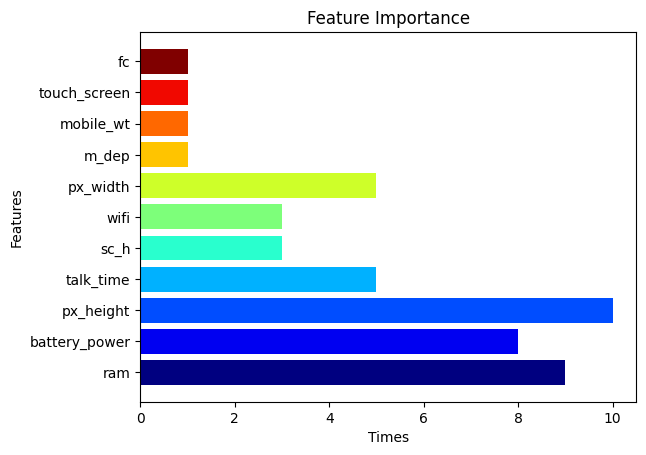

In [202]:
features = {}

#calculate features times
for i in clf_depth10.features :
    if features.get(feature_names[i]) == None :
        features[feature_names[i]] = 1
    else :
        features[feature_names[i]] += 1
        
#use barh to produce chart
cmap = cm.jet(np.linspace(0, 1, len(features)))
plt.barh(*zip(*features.items()), color=cmap)
plt.ylabel('Features')
plt.xlabel('Times')
plt.title('Feature Importance')
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [9]:
#relabel the y val
def relabel(y_data) :
    for  i in range(len(y_data)) :
        if y_data[i] == 0 :
            y_data[i] = -1

    return y_data 

#compute error
def compute_error(y, y_pred, w_i):
    
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))

#compute alpha
def compute_alpha(error):
    
    return np.log((1 - error) / error) / 2

#refresh weights
def update_weights(w_i, alpha, y, y_pred):
    # print(np.not_equal(y, y_pred))
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

class AdaBoost():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.acc = 0
        self.tree = None
        self.alphas = []
        self.clf = []   
    
    #fit decison tree with adaboost approach
    def fit(self, x_data, y_data):  
        y_data = y_data * 2 - 1
        #iterate through n_estimaters
        for m in tqdm(range(0, self.n_estimators)):
            
            if m == 0:
                #initiate weight
                w_i = np.ones(len(y_data)) * 1 / len(y_data)
                
                new_x = x_data
            else:
                #refresh weight and normalize
                w_i = update_weights(w_i, alpha, y_data, y_pred)
                w_i = w_i/sum(w_i)
                #sample data with weight
                idx = np.random.choice(len(x_data), len(x_data), replace = True, p = w_i)
                new_x = x_data[idx]

            #run decision tree
            clf_depth3 = DecisionTree(criterion='gini', max_depth=1)
            clf_depth3.fit(new_x, y_data, ada = True , sample_weight = w_i)
            y_pred = clf_depth3.predict(x_data)
            #relabel y_pred
            y_pred = y_pred * 2 -1
            #strore ecison tree
            self.clf.append(clf_depth3)

            error = compute_error(y_data, y_pred, w_i)

            alpha = compute_alpha(error)
            #store alpha
            self.alphas.append(alpha)
    #decide which class it is    
    def result(self, pred) :
        y_pred = []
        for i in pred : 
            if i >= 0 :
                y_pred.append(1)
            else :
                y_pred.append(0)

        return np.asarray(y_pred)

    #predict y val with sum result
    def predict(self, x_data):
        preds = np.zeros(len(x_data))

        for m in range(self.n_estimators):
            y_pred_m = self.clf[m].predict(x_data) * 2 - 1
            y_pred_m = y_pred_m * self.alphas[m]
            preds += y_pred_m
            
        #find predict class
        y_pred = self.result(preds)
        return y_pred

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [209]:
ada10 = AdaBoost(n_estimators=10)
ada100 = AdaBoost(n_estimators=100)

ada10.fit(x_train, y_train)
y_pred = ada10.predict(x_test)
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

ada100.fit(x_train, y_train)
y_pred = ada100.predict(x_test)
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

100%|██████████| 10/10 [05:50<00:00, 35.06s/it]


Test-set accuarcy score:  0.8933333333333333


100%|██████████| 100/100 [57:40<00:00, 34.60s/it]

Test-set accuarcy score:  0.9233333333333333


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [10]:
#coutnt label for class find the most class
def common_label(y_data) :
    counter = Counter(y_data)
    label = counter.most_common(1)[0][0]
    return label

class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = math.ceil(max_features)
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree = []

    def fit(self, x_data, y_data):
        #iterate through the n_estimater
        for i in tqdm(range(self.n_estimators)) :
            clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
            #randomly choose data 
            idx = np.random.choice(len(x_data), len(x_data), replace = True)
            new_x, new_y = x_data[idx], y_data[idx]
            clf_depth3.fit(new_x, new_y, boostrap=self.boostrap, max_features=self.max_features)
            self.tree.append(clf_depth3)

    #predict label with randomforest
    def predict(self, x_data):
        tree_predicts = np.array([tree.predict(x_data) for tree in self.tree])
        tree_predicts = np.swapaxes(tree_predicts, 0, 1)
        y_pred = [common_label(tree_pred) for tree_pred in tree_predicts]
        return np.array(y_pred)

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [170]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

In [172]:
clf_10tree.fit(x_train, y_train)
y_pred = clf_10tree.predict(x_test)
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

clf_100tree.fit(x_train, y_train)
y_pred = clf_100tree.predict(x_test)
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

100%|██████████| 10/10 [00:46<00:00,  4.68s/it]


Test-set accuarcy score:  0.87


100%|██████████| 100/100 [06:48<00:00,  4.08s/it]

Test-set accuarcy score:  0.9133333333333333


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [164]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [166]:
clf_random_features.fit(x_train, y_train)
y_pred = clf_random_features.predict(x_test)
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

clf_all_features.fit(x_train, y_train)
y_pred = clf_all_features.predict(x_test)
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


Test-set accuarcy score:  0.89


100%|██████████| 10/10 [03:17<00:00, 19.71s/it]

Test-set accuarcy score:  0.91


### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [11]:
def train_your_model(data):
    ## Define your model and training 
    data_x_train = np.array(data.values)[:,0:(len(val_df.values[0])-1)]
    data_y_train = np.array(data.values)[:,-1]
    
    ada175 = AdaBoost(n_estimators=175)
    ada175.fit(data_x_train, data_y_train)    
    # clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
    # clf_depth3.fit(data_x_train, data_y_train)
    # y_pred = clf_depth3.predict(x_test)
    # print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))
    return ada175


In [12]:

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
data = pd.concat([train_df, val_df])
data_x_train = data.values
# print(data_x_train)

my_model = train_your_model(data)
test_df = pd.read_csv('x_test.csv')
x_test = test_df.values
# print(x_test)
y_pred = my_model.predict(x_test)
np.save('y_pred', y_pred)
x = np.load('y_pred.npy')
# print('Test-set accuarcy score: ', accuracy_score(train_y, y_pred))
# print('Test-set accuarcy score: ', accuracy_score(train_y, x))

100%|██████████| 175/175 [1:39:52<00:00, 34.24s/it]


In [78]:
# x_train = pd.read_csv('x_test.csv')
# x_test = x_train.values
# y_pred = my_model.predict(x_test)


In [79]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [218]:
# import pandas as pd
# from sklearn.metrics import accuracy_score
# # y_test = pd.read_csv('y_test.csv')['price_range'].values

# print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

In [219]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


DecisionTree(criterion='entropy', max_depth=3) failed
*** We will check your result for Question 3 manually *** (5 points)


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 42.5 ~ 67.5
*** This score is only for reference ***
